# Analysis of VICTree output tree matrix

In [1]:
import h5py
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import time
from treesampling.algorithms import random_spanning_tree_log, CastawayRST, colbourn_rst, kirchoff_rst
from treesampling.algorithms.castaway_legacy import random_spanning_tree_log as rst_legacy
from treesampling.utils.graphs import reset_adj_matrix, tree_to_newick, tuttes_tot_weight
from treesampling.utils.visualization import plot_logweights_heatmap

In [2]:
# load h5 file
# this is partial run with wilson algorithm (matrix where wilson gets stuck)
vic_out = h5py.File("/Users/zemp/phd/scilife/victree-experiments/cnasim_performance/hg38_1_N200Z6F1/victree_out_wilsonqt/victree.out.h5ad", 'r')

## with victree-legacy sampling
# vic_out = h5py.File("/Users/zemp/phd/scilife/victree-experiments/cnasim_performance/data/hg38_N100Z6F0.1C0.02/victree_out_legacyqt/victree.out.h5ad", 'r')
# vic_out = h5py.File("/Users/zemp/phd/scilife/victree-experiments/SA501X3F/victree-out/K12/victree.out.h5ad", 'r')
graph_matrix = vic_out['uns']['victree-tree-graph'][:]
# tempering:
# graph_matrix = graph_matrix / 50
# graph_matrix = np.exp(graph_matrix)

In [26]:
import itertools
K = 6
ss = 500
graph = nx.complete_graph(K, create_using=nx.DiGraph)
for u, v in itertools.product(range(K), repeat=2):
    if v == 0 or u == v:
        graph_matrix[u, v] = -np.inf
graph = reset_adj_matrix(graph, graph_matrix)
nx.to_numpy_array(graph)

array([[           -inf, -5.53106880e+01, -4.08155518e+02,
        -5.04498444e+02, -1.07182263e+03, -1.53380013e+01,
        -2.17641748e+03, -5.99199463e+03, -1.53379974e+01,
        -1.53379974e+01],
       [           -inf,            -inf, -4.41990509e+02,
        -5.26375183e+02, -1.08963806e+03, -4.22997169e+01,
        -2.17801099e+03, -5.87612939e+03, -4.22997169e+01,
        -4.22997169e+01],
       [           -inf, -3.90922577e+02,            -inf,
        -6.86142212e+02, -1.20311511e+03, -3.63944427e+02,
        -2.15428101e+03, -4.73057617e+03, -3.63944427e+02,
        -3.63944427e+02],
       [           -inf, -3.16273468e+02, -5.54020874e+02,
                   -inf, -1.07047791e+03, -2.95583862e+02,
        -2.24310938e+03, -3.63921899e+03, -2.95583862e+02,
        -2.95583862e+02],
       [           -inf, -1.09302710e+03, -1.23187378e+03,
        -1.16125269e+03,            -inf, -1.07935327e+03,
        -2.24841187e+03, -3.71356372e+03, -1.07935327e+03,
        -1.

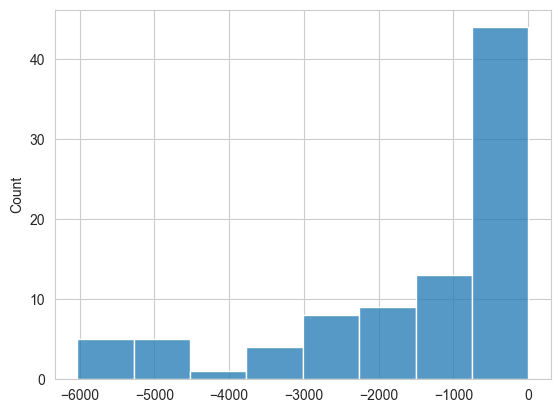

In [4]:
# histogram
g = sns.histplot(graph_matrix[~np.isinf(graph_matrix)])
# TODO: find why such skewed matrix don't run successfully in tree sampling

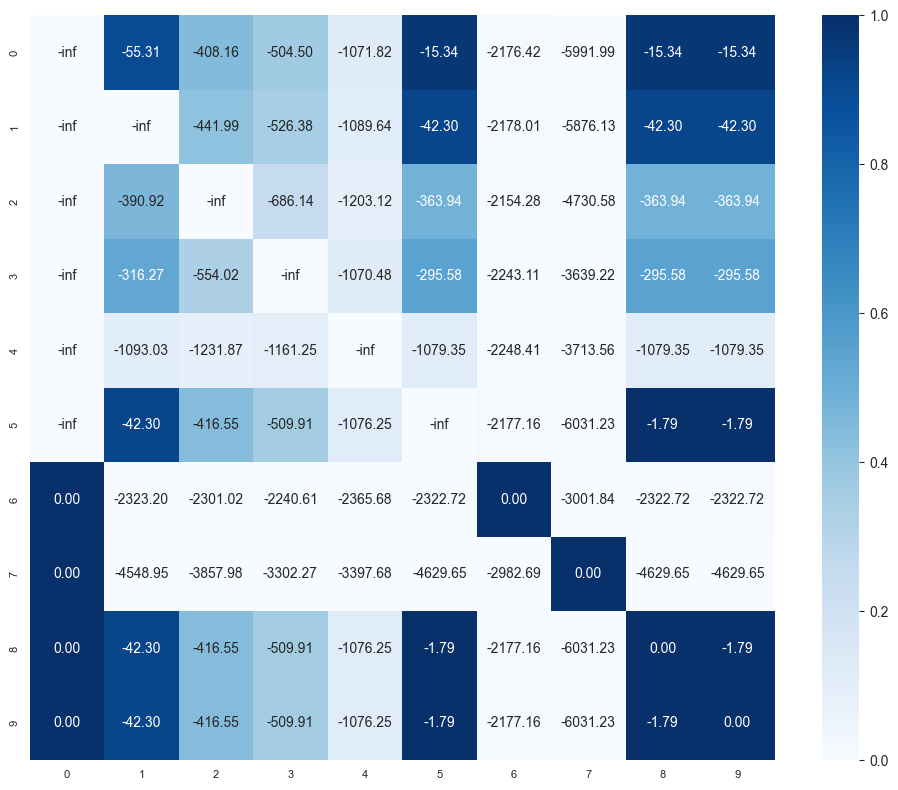

In [5]:
# heatmap
f, ax = plt.subplots(figsize=(10, 8)) ## here increased figsize
plot_logweights_heatmap(graph, ax=ax, color_tempering=500)
f.tight_layout()


In [6]:
# draw 100 trees and save them in dict
sample = {}
legacy_times = []
for i in range(ss):
    tree = None
    miss = 0
    start = time.time()
    while tree is None and miss < 20:
        try:
            tree = rst_legacy(graph, root=0)
        except ValueError as e:
            miss += 1
            tree = None

    if miss > 20:
        print(f"FAIL")
        continue
    elif miss > 0:
        print(f"WARN: Missed {miss} times")
    else:
        print(f"OK")

    legacy_times.append(time.time() - start)
    tnwk = tree_to_newick(tree)
    if tnwk not in sample:
        sample[tnwk] = 0
    sample[tnwk] += 1

sorted(sample.items(), key=lambda a: a[1], reverse=True)



/var/folders/kf/j5d6g9gd4tg5n6vzhr5p_1f00000gn/T/ipykernel_89570/290808423.py:10: DeprecationWarning: Use the new function castaway_rst with log_probs=True
  tree = rst_legacy(graph, root=0)


OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
OK
O

[('((6)2,(4,7)3,(1,8,9)5)0', 24),
 ('(((7)6)2,(4)3,(1,8,9)5)0', 22),
 ('(((7)6)2,(4)3,(1,(8)9)5)0', 19),
 ('((6)2,(4,7)3,(1,(9)8)5)0', 15),
 ('((6)2,(4,7)3,(1,(8)5)9)0', 12),
 ('(((7)6)2,(4)3,((1,9)5)8)0', 12),
 ('((6)2,(4,7)3,(1,(8)9)5)0', 11),
 ('(((7)6)2,(4)3,(8,(1)9)5)0', 10),
 ('(((7)6)2,(4)3,(1,5,9)8)0', 10),
 ('((6)2,(4,7)3,(1,5,8)9)0', 10),
 ('(1,(6)2,(4,7)3,(8,9)5)0', 9),
 ('(((7)6)2,(4)3,(1,(8)5)9)0', 9),
 ('(((7)6)2,(4)3,((1,8)5)9)0', 8),
 ('((6)2,(4,7)3,(1,(9)5)8)0', 8),
 ('((6)2,(4,7)3,(8,(1)9)5)0', 8),
 ('(((7)6)2,(4)3,(5,(1)9)8)0', 8),
 ('((6)2,(4,7)3,(((1)9)5)8)0', 8),
 ('((6)2,(4,7)3,(1,5,9)8)0', 7),
 ('(((7)6)2,(4)3,((1,5)8)9)0', 7),
 ('(((7)6)2,(4)3,((1)5,9)8)0', 7),
 ('(((7)6)2,(4)3,((1,8)9)5)0', 7),
 ('((6)2,(4,7)3,((1,5)8)9)0', 6),
 ('((6)2,(4,7)3,((1,9)5)8)0', 6),
 ('(((7)6)2,(4)3,((1)8,9)5)0', 6),
 ('((6)2,(7)3,4,(1,8,9)5)0', 6),
 ('(((7)6)2,3,4,((1)5,9)8)0', 5),
 ('(((7)6)2,(4)3,(((1)9)5)8)0', 5),
 ('(((7)6)2,3,4,(1,(8)9)5)0', 5),
 ('((6)2,(4,7)3,((1,8)9)5)0', 

In [7]:
# draw 100 trees and save them in dict
sample = {}
for i in range(ss):
    miss = 0
    tree = None
    while tree is None and miss < 20:
        try:
            sampler = CastawayRST(graph, root=0, log_probs=True, trick=True)
            tree = sampler.sample_tree()
        except ValueError as e:
            miss += 1
            tree = None
        if miss > 20:
            print(f"FAIL")
            continue
    tnwk = tree_to_newick(tree)
    if tnwk not in sample:
        sample[tnwk] = 0
    sample[tnwk] += 1

sorted(sample.items(), key=lambda a: a[1], reverse=True)

edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:48: RuntimeWarning: invalid value encountered in subtract
  return arr - sp.logsumexp(arr, axis=axis, keepdims=True)
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6 has weight 1.0, all other edges in node 6 will be set to 0.
edge 7 -> 7 has weight 1.0, all other edges in node 7 will be set to 0.
Error computing Ry(u) = 1 / (1 - Ry_1(u))
Ry_1(u) = nan
edge 6 -> 6

AttributeError: 'NoneType' object has no attribute 'is_directed'

In [8]:
vic_out.uns['victree-tree-newick']

AttributeError: 'File' object has no attribute 'uns'

In [21]:
vic_out.uns['victree-tree-probs']

array([nan, nan], dtype=float32)

In [8]:
from treesampling.algorithms import wilson_rst
import time
# NOTE: this takes too long
# draw 20 trees and compute avg time
times = []
for i in range(20):
    start = time.time()
    tree = wilson_rst(graph, root=0, log_probs=True)
    times.append(time.time() - start)


In [9]:
print(f"Average time Wilson (seconds for one tree): {np.mean(times):.5f} +- {np.std(times):.5f}")
# against legacy:
print(f"Average time Legacy Castaway (seconds for one tree): {np.mean(legacy_times):.5f} +- {np.std(legacy_times):.5f}")

Average time Wilson (seconds for one tree): 5.06252 +- 5.58623
Average time Legacy Castaway (seconds for one tree): 0.00420 +- 0.00145


In [12]:
from treesampling.utils.graphs import tuttes_tot_weight
# determinant computation - not possible with log graph..
# try with preprocessing of the graph (filter out < -thresh and set to -inf)
tot_weight_estimate = tuttes_tot_weight(graph, root=0)
print(tot_weight_estimate)

nan


In [13]:
sample = {}
for i in range(ss):
    tree = kirchoff_rst(graph, root=0, log_probs=True)
    tnwk = tree_to_newick(tree)
    if tnwk not in sample:
        sample[tnwk] = 0
    sample[tnwk] += 1

sorted(sample.items(), key=lambda a: a[1], reverse=True)

IndexError: pop from empty list

In [36]:
from treesampling.utils.graphs import normalize_graph_weights
matrix = nx.to_numpy_array(graph)
matrix[:, 0] = 0.
matrix[0, 0] = -np.inf
print(matrix)
kirch_graph = reset_adj_matrix(graph, matrix)
# normalize graph weights
kirch_graph = normalize_graph_weights(kirch_graph, log_probs=True)
min_log_weight = np.log(np.nextafter(0, 1))
matrix[matrix < min_log_weight] = -np.inf
W = np.exp(matrix)
print(W)
print(np.all(np.isclose(W, 0.), axis=1))
W[:, np.all(np.isnan(W), axis=0)] = 1.
kirch_graph = reset_adj_matrix(kirch_graph, W)
kirch_graph = normalize_graph_weights(kirch_graph, log_probs=False)
nx.to_numpy_array(kirch_graph)
# FIXME: find a way of preprocessing this matrix for kirchoff/colbourn algorithms


[[           -inf -5.53106880e+01 -4.08155518e+02 -5.04498444e+02
  -1.07182263e+03 -1.53380013e+01 -2.17641748e+03 -5.99199463e+03
  -1.53379974e+01 -1.53379974e+01]
 [ 0.00000000e+00            -inf -4.41990509e+02 -5.26375183e+02
  -1.08963806e+03 -4.22997169e+01 -2.17801099e+03 -5.87612939e+03
  -4.22997169e+01 -4.22997169e+01]
 [ 0.00000000e+00 -3.90922577e+02            -inf -6.86142212e+02
  -1.20311511e+03 -3.63944427e+02 -2.15428101e+03 -4.73057617e+03
  -3.63944427e+02 -3.63944427e+02]
 [ 0.00000000e+00 -3.16273468e+02 -5.54020874e+02            -inf
  -1.07047791e+03 -2.95583862e+02 -2.24310938e+03 -3.63921899e+03
  -2.95583862e+02 -2.95583862e+02]
 [ 0.00000000e+00 -1.09302710e+03 -1.23187378e+03 -1.16125269e+03
             -inf -1.07935327e+03 -2.24841187e+03 -3.71356372e+03
  -1.07935327e+03 -1.07935327e+03]
 [ 0.00000000e+00 -4.22997055e+01 -4.16546234e+02 -5.09914154e+02
  -1.07624695e+03            -inf -2.17715625e+03 -6.03122754e+03
  -1.79176116e+00 -1.79176116e+00

/Users/zemp/PycharmProjects/treesampling/src/treesampling/utils/math.py:50: RuntimeWarning: invalid value encountered in divide
  return arr / np.sum(arr, axis=axis, keepdims=True)


array([[0.00000000e+000, 7.45216944e-007, 9.99319570e-001,
        9.86837041e-001,             nan, 6.54504140e-007,
                    nan,             nan, 6.54505544e-007,
        6.54505544e-007],
       [1.11111111e-001, 0.00000000e+000, 2.02001367e-015,
        3.11385363e-010,             nan, 1.27816832e-018,
                    nan,             nan, 1.27816618e-018,
        1.27816618e-018],
       [1.11111111e-001, 1.31187156e-152, 0.00000000e+000,
        1.28043988e-079,             nan, 2.61857566e-158,
                    nan,             nan, 2.61857129e-158,
        2.61857129e-158],
       [1.11111111e-001, 3.44815981e-120, 4.47904048e-064,
        0.00000000e+000,             nan, 1.27844299e-128,
                    nan,             nan, 1.27844086e-128,
        1.27844086e-128],
       [1.11111111e-001, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000,             nan, 0.00000000e+000,
                    nan,             nan, 0.00000000e+000,
        0.0